In [63]:
import numpy as np
import cv2
import os
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans
from typing import List, T
from sklearn.model_selection import train_test_split

In [65]:
dataset_path = 'caltech-101/101_ObjectCategories'
test_size = 0.2
k = 500

In [116]:
categories = []
for root, dirs, files in os.walk(dataset_path):
    for dir in dirs:
        
        for cat_root, cat_dirs, cat_files in os.walk(os.path.join(dataset_path, dir)):
            
            if len(cat_files) >= 100:
                categories.append(dir)
                print(dir, len(cat_files))
              

      

hawksbill 100
chandelier 107
airplanes 800
ketch 114
bonsai 128
Leopards 200
car_side 123
watch 239
Motorbikes 798
BACKGROUND_Google 468
Faces_easy 435
Faces 435


In [64]:
def get_file_paths(dataset_path : str, category : str, test_size : float) -> List[str]:
    """ 
    returns names of files for test and train datasets of particular category
    """
    files_paths = []
    for root, dirs, files in os.walk(os.path.join(dataset_path, category)):
        for name in files:
            files_paths.append(os.path.join(root, name))
    train_files, test_files = train_test_split(files_paths, test_size=test_size)
    return train_files, test_files

def load_images(files_paths : List[str]) -> List[np.ndarray]:
    images = []
    for file in files_paths:
        img = cv2.imread(file,0)
        images.append(img)
    return images
        

In [66]:
# creating train and test datasets 
train_images = {}
test_images = {}
for cat in categories:
    train_files, test_files = get_file_paths(dataset_path, cat, test_size)
    train_images[cat] = load_images(train_files)
    test_images[cat] = load_images(test_files)

In [67]:
def sift_features(images):
    descriptor_dict = {}
    descriptor_list = []
    sift = cv2.xfeatures2d.SIFT_create()
    for category, cat_images in images.items():
        features = []
        for img in cat_images:
            kp, des = sift.detectAndCompute(img,None)
            descriptor_list.extend(des)
            features.append(des)
        descriptor_dict[category] = features
    return [descriptor_list, descriptor_dict]

descriptor_list, all_bovw_feature = sift_features(train_images) 
_, test_bovw_feature = sift_features(test_images)
# descriptor_list is needed for creating clustering centers, so we only take them from train dataset
# bovw_feature for train and test are needed for classification of the image 

In [68]:
# Returns an array that holds central points (visual words)
def kmeans(k, descriptor_list):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(descriptor_list)
    visual_words = kmeans.cluster_centers_ 
    return visual_words
  
visual_words = kmeans(k, descriptor_list) 

In [69]:
def find_index(feature : np.ndarray, centers : np.ndarray):
    # returns an index of the visual word that is the most similar to a feature 
    minimum = 0
    start_min = True 
    min_index = 0 
    for idx, center in enumerate(centers): 
        distance_c = distance.cosine(center, feature)
        if start_min:
            minimum = distance_c
            start_min = False 
        else: 
            minimum = min(minimum, distance_c)
            if minimum == distance_c:
                min_index = idx

    return min_index

In [70]:
# Takes 2 parameters: 
# - a dictionary that holds the descriptors that are separated class by class 
# - an array that holds the central points (visual words) of the k means clustering
# Returns a dictionary that holds the histograms for each images that are separated class by class. 
def image_class(all_bovw, centers):
    bovw = {}
    for key,value in all_bovw.items():
        category = []
        for img in value:
            histogram = np.zeros(len(centers))
            for feature in img:
                ind = find_index(feature, centers)
                histogram[ind] += 1
            category.append(histogram)
        bovw[key] = category
    return bovw
    
# Creates histograms for train data    
bovw_train = image_class(all_bovw_feature, visual_words) 
# Creates histograms for test data
bovw_test = image_class(test_bovw_feature, visual_words) 

In [117]:
import json

def save_to_json(file_name, bovw):
    bovw_list = {cat : list(bovw[cat][0]) for cat in bovw.keys()}
    json_object = json.dumps(bovw_list)
    with open(file_name, 'w') as outfile:
        outfile.write(json_object)

save_to_json('bovw_test.json', bovw_test)
save_to_json('bovw_train.json', bovw_train)
 

In [119]:
# 1-NN algorithm. We use this for predict the class of test images.
# Takes 2 parameters
# - images : feature vectors of train images 
# - tests : feature vectors of test images
# Returns an array that holds number of test images, number of correctly predicted images and records of class based images respectively
def knn(images, tests):
    num_test = 0
    correct_predict = 0
    class_based = {}
    
    for test_category, test_histograms_list in tests.items():
        class_based[test_category] = [0, 0] # [correct, all]
        for test_histogram in test_histograms_list:
            min_start = True 
            for train_category, train_histograms_list in images.items():
                for train_histogram in train_histograms_list:
                    if min_start:
                        minimum = distance.euclidean(test_histogram, train_histogram)
                        pred = train_category
                        min_start = False
                    else:
                        dist = distance.euclidean(test_histogram, train_histogram)
                        if(dist < minimum):
                            minimum = dist
                            pred = train_category
            
            if(test_category == pred):
                correct_predict += 1
                class_based[test_category][0] += 1
            num_test += 1
            class_based[test_category][1] += 1

    return [num_test, correct_predict, class_based]
    
# Call the knn function    
results_bowl = knn(bovw_train, bovw_test) 

In [120]:
# Calculates the average accuracy and class based accuracies.  
def accuracy(results):
    avg_accuracy = (results[1] / results[0]) * 100
    print("Average accuracy: %" + str(avg_accuracy))
    print("\nClass based accuracies: \n")
    for key,value in results[2].items():
        acc = (value[0] / value[1]) * 100
        print(key + " : %" + str(acc))
        
# Calculates the accuracies and write the results to the console.       
accuracy(results_bowl) 

Average accuracy: %40.0

Class based accuracies: 

umbrella : %20.0
airplanes : %72.5
bonsai : %42.30769230769231
flamingo : %21.428571428571427
watch : %39.58333333333333
sea_horse : %25.0
saxophone : %0.0
scissors : %37.5
pizza : %18.181818181818183
kangaroo : %22.22222222222222
lamp : %7.6923076923076925
lotus : %14.285714285714285
helicopter : %5.555555555555555
okapi : %0.0
pagoda : %10.0
elephant : %15.384615384615385
electric_guitar : %20.0
crocodile : %0.0
butterfly : %10.526315789473683


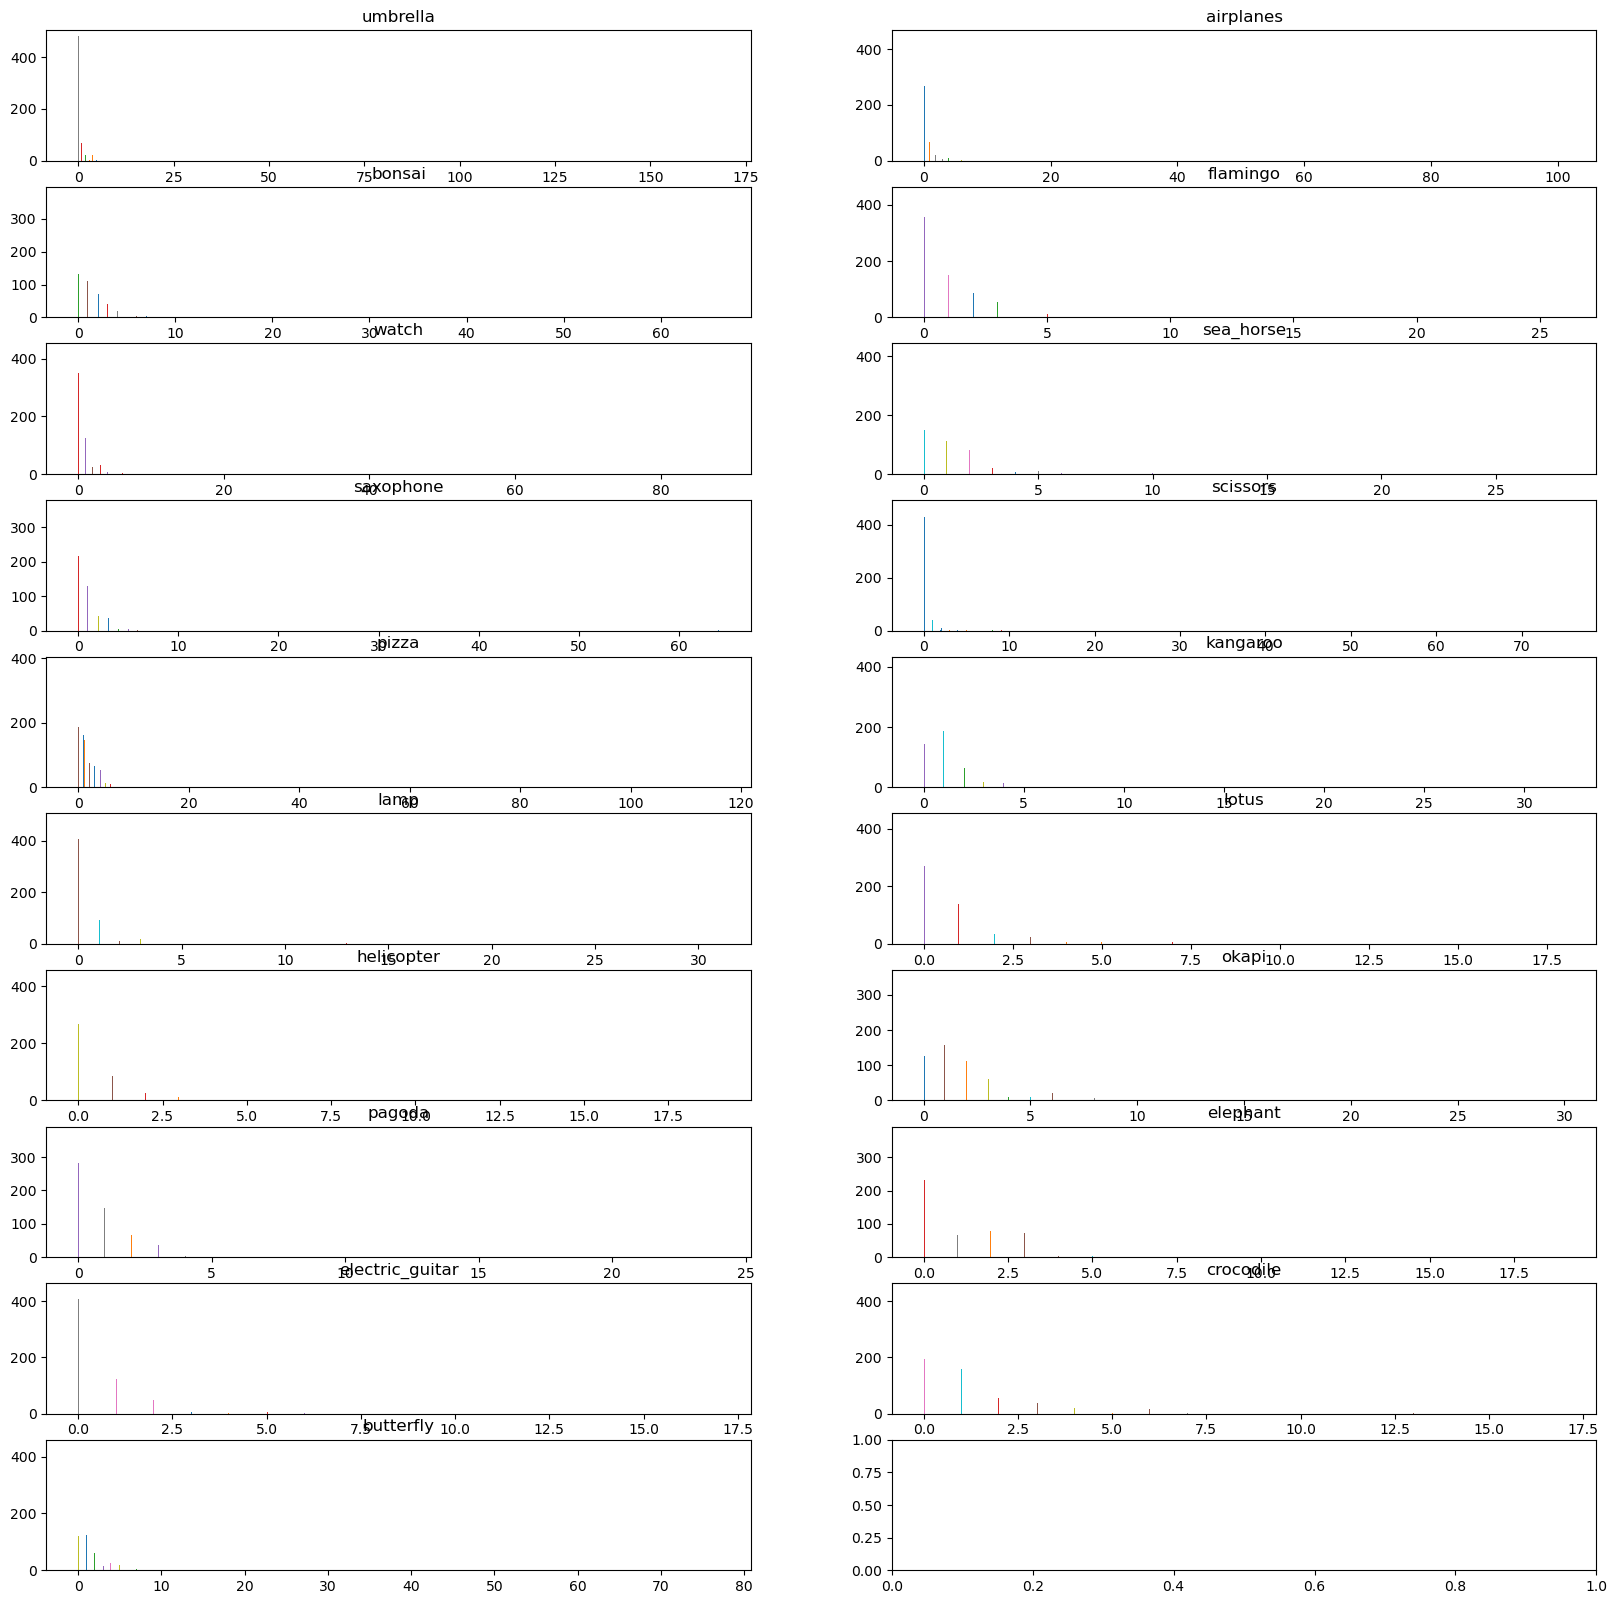

In [82]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(6, 2)
fig.set_size_inches(20, 20)
for ax, cat in zip(axes, categories):
    ax[0].hist(bovw_train[cat], bins=k)
    ax[0].set_title(f'{cat} train histogram')
    ax[1].hist(bovw_test[cat], bins=k)
    ax[1].set_title(f'{cat} test histogram')

plt.show()